# Rental Price Preprocessing Appraoch Overview

We want to preprocess rental price for all instances into integers. In summary, we have found these type of price:

*Weekly rent only*

*   `520pw`
*   `$650.00 per week`
*   `$650 p.w.`
*   `$395 per week`
*   `$580 per weekly - Unfurnished`
*   `$160-$200 weekly`:

*Weekly + Monthly rent*

*   `$2300pw \ $9994pcm`
*    `545 PW \ $2368 PCM`
*    `$690pw\$2998pcm`

*Undefined rent* (will be assumed as weekly rent)
*   `$750 **SPACIOUS APARTMENT**`
*   `$320 OR $320.00` 
*   `$490 Fully Furnished`

*Others (will be dropped)*

*   `Contact Agent`: no value
*   `$2384 calendar month`: monthly rent
*   `$33,000 Per Year`: annual rent
*   `160 per night`
*   `1Bed + 1Study $560 Negotiable`

As we will only be analysising with weekly rent, we will use regular expression to extract the weekly rent. In general, we generated 4 types of regular expression:
*   --TYPE1-- **price value with `'w'`**: 
    *   The common characteristic betweem 'pw', 'per week', 'weekly' etc. is that they all have 'w' in their unit. Thus by extracting price followed by w, we can aviod extracting monthly rent.
*   --TYPE2--  **price value only**: 
    *   We assume if the price discription contains value only, it is the weekly rent.
*   --TYPE3-- **price value ended with `'d'`**: 
    *   From expirements, we discovered that there are many instances which didn't specify weekly rent however specified 'furnished' eg`$490 Fully Furnished`, we will assume these as weekly rent.
*   --TYPE4--**price value with `**discription**`**: 
    *   We also discovered many price looked like `$750 **SPACIOUS APARTMENT**`, hence we assume those are weekly rent.

In [27]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

# RE version

In [28]:
df = pd.read_csv("../../data/raw/API_Raw_PropertiesInfo.csv")
df['price'] = df["price"].str.replace(",","")
df['price'] = df["price"].str.replace(" ","_") # replacing blank space with underline will simplify code in regex

regex_str1 = r'([$]?\d+[.]?\d+\w+[.]*\w*[/]*\w*[wW])' # $650.00 per week
regex_str2 = r'([$]?\d+[.]?\d+$)' # $320
regex_str3 = r'([$]?\d+[.]?\d+\w+[-]?\w+[d]$)' # $490 Fully Furnished
regex_str4 = r'([$]?\d+[.]?\d+\w*[*]+\w*[*]+$)' # $750_**SPACIOUS_APARTMENT**

df['price1']=df['price'].str.extract(regex_str1)
df['price2']=df['price'].str.extract(regex_str2)
df['price3']=df['price'].str.extract(regex_str3)
df['price4']=df['price'].str.extract(regex_str4)


In [29]:
df['weekly_rent'] = df['price1'].where(df['price1'].notnull(), df['price2'])
df['weekly_rent'] = df['weekly_rent'].where(df['weekly_rent'].notnull(), df['price3'])
df['weekly_rent'] = df['weekly_rent'].where(df['weekly_rent'].notnull(), df['price4'])
df = df.drop(['price1','price2','price3', 'price4'],axis=1)
#dff = df[['price', 'weekly_rent']]
#dff.to_csv("re.csv")
#dff1 = dff[dff['weekly_rent'].isna()] #just for checking
#dff1.to_csv('re_null.csv')
df2 = df.dropna(subset = ['weekly_rent'])
df2['weekly_rent'] = df2['weekly_rent'].str.extract('(\d+)').astype(int)

df3 = df2[df2['weekly_rent'] > 10000] # drop the yearly rent ones.
result =  df2[df2['weekly_rent'] < 10000]
result.to_csv("../../data/curated/API_re_clean.csv")

print(f'{len(df) - len(df2)} instances were dropped as no weekly rent was demonstrated')
print(f'{len(df3)} instances were dropped as it was annual rent')


<ipython-input-29-6af63d129efe>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['weekly_rent'] = df2['weekly_rent'].str.extract('(\d+)').astype(int)


483 instances were dropped as no weekly rent was demonstrated
1 instances were dropped as it was annual rent


(array([1.730e+02, 4.686e+03, 7.081e+03, 1.760e+03, 5.360e+02, 1.740e+02,
        1.050e+02, 5.500e+01, 3.700e+01, 2.900e+01, 8.000e+00, 6.000e+00,
        2.000e+01, 3.000e+00, 5.000e+00, 2.000e+00, 0.000e+00, 5.000e+00,
        4.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([1.00000000e+00, 2.00966667e+02, 4.00933333e+02, 6.00900000e+02,
        8.00866667e+02, 1.00083333e+03, 1.20080000e+03, 1.40076667e+03,
        1.60073333e+03, 1.80070000e+03, 2.00066667e+03, 2.20063333e+03,
        2.40060000e+03, 2.60056667e+03, 2.80053333e+03, 3.00050000e+03,
        3.20046667e+03, 3.40043333e+03, 3.60040000e+03, 3.80036667e+03,
        4.00033333e+03, 4.20030000e+03, 4.40026667e+03, 4.60023333e+03,
        4.80020000e+03, 5.00016667e+03, 5.20013333e+03, 5.40010000e+03,
        5.60006667e+03, 5.80003333e+03, 6.00000000e+03]),
 <BarContainer object of 30 artists>)

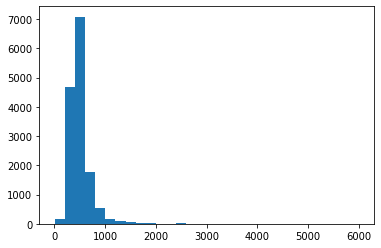

In [30]:
plt.hist(result['weekly_rent'], bins=30)

(array([2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.0000e+00, 0.0000e+00, 6.0000e+00, 0.0000e+00,
        2.4000e+01, 0.0000e+00, 5.0000e+00, 0.0000e+00, 0.0000e+00,
        3.0000e+00, 0.0000e+00, 8.0000e+00, 0.0000e+00, 2.7000e+01,
        0.0000e+00, 4.6000e+01, 0.0000e+00, 7.6000e+01, 0.0000e+00,
        2.2700e+02, 0.0000e+00, 3.8200e+02, 0.0000e+00, 1.3887e+04]),
 array([2008.        , 2008.46666667, 2008.93333333, 2009.4       ,
        2009.86666667, 2010.33333333, 2010.8       , 2011.26666667,
        2011.73333333, 2012.2       , 2012.66666667, 2013.13333333,
        2013.6       , 2014.06666667, 2014.53333333, 2015.        ,
        2015.46666667, 2015.93333333, 2016.4       , 2016.86666667,
        2017.33333333, 2017.8       , 2018.26666667, 2018.73333333,
        2019.2       , 2019.66666667, 2020.13333333, 2020.6       ,
        2021.06666667, 2021.53333333, 2022.        ]),
 <BarContainer object of 30 artists>)

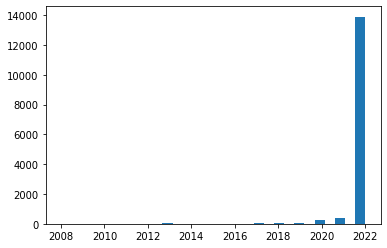

In [31]:

# pd.Timestamp(result['time_listed'])
#result['time_listed'].to_timestamp()

df2 = pd.to_datetime(result['time'])
years = df2.dt.year
years
plt.hist(years, bins=30)